In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline
%autoreload 1
import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

from scipy import integrate, interpolate, stats, signal
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

%aimport util
from plot_helper import *


Matplotlib Version: 3.6.3


In [3]:
plot_styles = [
    ("./white_background_ctl.mplstyle", ""),
    ("./dark_background_ctl.mplstyle", "_dark"),
]

In [4]:
from MDAnalysis.analysis.leaflet import LeafletFinder


def largest_groups(atoms):
    """
    From a list of sizes, find out the indices of the two largest groups. These should correspond to the two leaflets of the bilayer.

    Keyword arguments:
    atoms -- list of sizes of clusters identified by LeafletFinder
    """
    largest = 0
    second_largest = 0

    for i in atoms:
        if atoms[i] > largest:
            largest_index = i
            largest = atoms[i]

    for i in atoms:
        if atoms[i] > second_largest and i != largest_index:
            second_largest_index = i
            second_largest = atoms[i]

    return (largest_index, second_largest_index)


def determine_leaflets(universe, selection="all"):
    """
    From a selection of phosphates, determine which belong to the upper and lower leaflets.

    Keyword arguments:
    universe -- an MDAnalysis Universe object
    phosphateSelection -- a string specifying how to select the phosphate atoms (e.g. "name P1")
    """
    leaflets = {}

    # calculate the z value of the phosphates defining the bilayer (assumes bilayer is in x and y..)
    ag = universe.atoms.select_atoms(selection)
    bilayerCentre = ag.center_of_geometry()[2]

    # apply the MDAnalysis LeafletFinder graph-based method to determine the two largest groups which
    #  should correspond to the upper and lower leaflets
    phosphates = LeafletFinder(universe, selection)

    # find the two largest groups - required as the first two returned by LeafletFinder, whilst usually are the largest, this is not always so
    (a, b) = largest_groups(phosphates.sizes())

    # check to see where the first leaflet lies
    if phosphates.group(a).centroid()[2] > bilayerCentre:
        leaflets["upper"] = phosphates.group(a)
        leaflets["lower"] = phosphates.group(b)
    else:
        leaflets["lower"] = phosphates.group(a)
        leaflets["upper"] = phosphates.group(b)

    return leaflets


In [5]:
lipids = ["POPC", "DOPC", "POPE", "DOPE", "CDL1", "CDL2", "POPG", "DOPG"]
leaflets = ["upper", "lower"]

queries = {
    "PC": "resname POPC or resname DOPC",
    "PE": "resname POPE or resname DOPE",
    "CDL": "resname CDL1 or resname CDL2",
    "PG": "resname POPG or resname DOPG",
}

po4_neighbor_sel = "name PO4 or name GL0"


def get_midpoints(x):
    return ((x + np.roll(x, -1)) / 2)[:-1]


In [6]:
def fftAutocovariance(signal):
    """
    FFT based calculation of the autocovariance function <df(0) - df(t)> without wrapping
    """
    centered_signal = signal - np.mean(signal, axis=0)
    zero_padding = np.zeros_like(centered_signal)
    padded_signal = np.concatenate((centered_signal, zero_padding))
    ft_signal = np.fft.fft(padded_signal, axis=0)
    pseudo_autocovariance = np.fft.ifft(np.abs(ft_signal) ** 2, axis=0)
    input_domain = np.ones_like(centered_signal)
    mask = np.concatenate((input_domain, zero_padding))
    ft_mask = np.fft.fft(mask, axis=0)
    mask_correction_factors = np.fft.ifft(np.abs(ft_mask) ** 2, axis=0)
    autocovariance = pseudo_autocovariance / mask_correction_factors
    return np.real(autocovariance[0 : len(signal)])


def fftAutocorrelation(signal):
    """
    FFT calculation of the normalized autocorrelation <df(0) - df(t)>/var(f) without wrapping
    """
    autocovariance = fftAutocovariance(signal)
    variance = autocovariance[0]
    # if variance == 0.:
    #     return np.zeros(autocovariance.shape)
    # else:
    return autocovariance / variance

def wrap_and_sanitize(pxy, ts, mc):
    """Wrap coordinates and remove values too far from closest known point

    Args:
        pxy (np.ndarray): XY coordinates
        ts: MDAnalysis timestep object
        mc: curvature object

    Returns:
        _type_: _description_
    """
    gx = mc.x_range[1] - mc.x_step
    
    # wrap PBC if point is more than half step greater than the closest data value
    if ts.dimensions[0] > mc.x_range[1] - mc.x_step / 2:
        pxy = np.where(pxy > gx + mc.x_step / 2, pxy - ts.dimensions[0], pxy)
    # Remove values which are too far from a known data point
    pxy = pxy[(pxy >= -mc.x_step / 2).all(axis=1), :]
    return pxy


In [17]:
cross_leaflet_correlation = {}

frames_to_average = 5
sets_to_consider = 200


for sim in np.concatenate((util.simulations, ["1_vbt"])):
    cross_leaflet_correlation[sim] = {}

    print(f"sim {sim}")
    with open(
        util.analysis_path / f"{sim}/membrane_curvature_2nm.pickle", "rb"
    ) as handle:
        mc = pickle.load(handle)

    h = mc.results["height"][1:]
    # mean_curvatures = np.zeros_like(h)
    # for i in range(h.shape[0]):
    #     mean_curvatures[i] = util.mean_curvature(h[i], mc.x_step)

    gro = util.analysis_path / f"{sim}/po4_only.gro"
    traj = util.analysis_path / f"{sim}/po4_all.xtc"

    u = MDAnalysis.Universe(gro, str(traj), refresh_offsets=True)
    ag = determine_leaflets(u, po4_neighbor_sel)

    for k, query in queries.items():
        print(f"analyzing lipid {k}")

        if len(u.select_atoms(query)) == 0:
            continue

        binned_lipid_density_upper = np.zeros(
            (sets_to_consider, h.shape[1], h.shape[2])
        )
        binned_lipid_density_lower = np.zeros(
            (sets_to_consider, h.shape[1], h.shape[2])
        )

        for i in range(sets_to_consider):
            upper_positions = []
            lower_positions = []

            if i == 0:
                for ts in u.trajectory[-frames_to_average:]:
                    xy = wrap_and_sanitize(
                        ag["upper"].select_atoms(query).positions[:, 0:2], ts, mc
                    )
                    upper_positions.append(xy)
                    xy = wrap_and_sanitize(
                        ag["lower"].select_atoms(query).positions[:, 0:2], ts, mc
                    )
                    lower_positions.append(xy)
            else:
                for ts in u.trajectory[
                    -frames_to_average * (i + 1) : -frames_to_average * i
                ]:
                    xy = wrap_and_sanitize(
                        ag["upper"].select_atoms(query).positions[:, 0:2], ts, mc
                    )
                    upper_positions.append(xy)
                    xy = wrap_and_sanitize(
                        ag["lower"].select_atoms(query).positions[:, 0:2], ts, mc
                    )
                    lower_positions.append(xy)
            # Convert to numpy array
            upper_positions = np.vstack(upper_positions)
            lower_positions = np.vstack(lower_positions)

            binned_lipid_density_upper[i], xe, ye = np.histogram2d(
                upper_positions[:, 0],
                upper_positions[:, 1],
                bins=mc.n_x_bins,
                range=[
                    [mc.x_range[0] - mc.x_step / 2, mc.x_range[1] - mc.x_step / 2],
                    [mc.y_range[0] - mc.x_step / 2, mc.y_range[1] - mc.x_step / 2],
                ],
                density=True,
            )

            binned_lipid_density_lower[i], xe, ye = np.histogram2d(
                lower_positions[:, 0],
                lower_positions[:, 1],
                bins=mc.n_x_bins,
                range=[
                    [mc.x_range[0] - mc.x_step / 2, mc.x_range[1] - mc.x_step / 2],
                    [mc.y_range[0] - mc.x_step / 2, mc.y_range[1] - mc.x_step / 2],
                ],
                density=True,
            )

        binned_lipid_density_upper -= np.mean(binned_lipid_density_upper)
        binned_lipid_density_lower -= np.mean(binned_lipid_density_lower)

        ## COMPUTE 2D SPATIAL CORRELATION
        acr = []
        for i in range(sets_to_consider):
            acr.append(
                signal.correlate2d(
                    binned_lipid_density_upper[i],
                    binned_lipid_density_lower[i],
                    boundary="wrap",
                )
                / binned_lipid_density_upper.shape[1] ** 2
                / (
                    np.std(binned_lipid_density_upper[i])
                    * np.std(binned_lipid_density_lower[i])
                )
            )

        acr = np.array(acr)
        acr = np.mean(acr, axis=0)

        center = int(acr.shape[0] / 2)

        cross_leaflet_correlation[sim][k] = [
            max(acr.min(), acr.max(), key=abs),
            acr.min(),
            acr.max(),
            acr.mean(),
            acr[20:23, 20:23].mean(),
            acr[center, center],
        ]

        # for style, style_ext in plot_styles:
        #     with plt.style.context(style):
        #         if style_ext:
        #             ecolor = "white"
        #         else:
        #             ecolor = "black"

        #         shape_size = xe[-1] / 10
        #         fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,
        #         im = ax.imshow(
        #             acr,
        #             vmin=-0.1,
        #             vmax=0.1,
        #             extent=[-shape_size, shape_size, -shape_size, shape_size],
        #             origin="lower",
        #         )

        #         fig.colorbar(im, ax=ax)
        #         ax.set_ylabel("Y (nm)")
        #         ax.set_xlabel("X (nm)")

        #         limits = (-20, 20)
        #         ax.set_xlim(*limits)
        #         ax.set_ylim(*limits)

        #         if sim == "1_vbt":
        #             fig.suptitle(f"1_vbt {k}")
        #         else:
        #             fig.suptitle(f"sim {util.sim_to_final_index[int(sim)]} {k}")

        #         fig.tight_layout()

        #         if sim == "1_vbt":
        #             save_fig(fig, curr_fig_path / f"1_vbt_correlation_{k}{style_ext}")
        #         else:
        #             save_fig(
        #                 fig,
        #                 curr_fig_path
        #                 / f"{util.sim_to_final_index[int(sim)]}_correlation_{k}{style_ext}",
        #             )

        #         if show_figs:
        #             plt.show()

        #         fig.clear()
        #         plt.close(fig)

sim 1


/home/ctlee/.conda/envs/mda/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 2
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 3
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 4
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 5
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 6
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 7
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 8
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 9
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 10
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 11
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 12
analyzing lipid PC
analyzing lipid PE
analyzing lipid CDL
analyzing lipid PG
sim 13


In [12]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


light_factor = 0.8

p = sns.color_palette("colorblind")

# palette = [lighten_color(p[i], j) for i, j in [(7, 1),(7, light_factor),(8,1),(8,light_factor),(0,1),(0,light_factor),(2,1),(2,light_factor)]]

# sns.palplot(palette)
# sns.palplot(p)


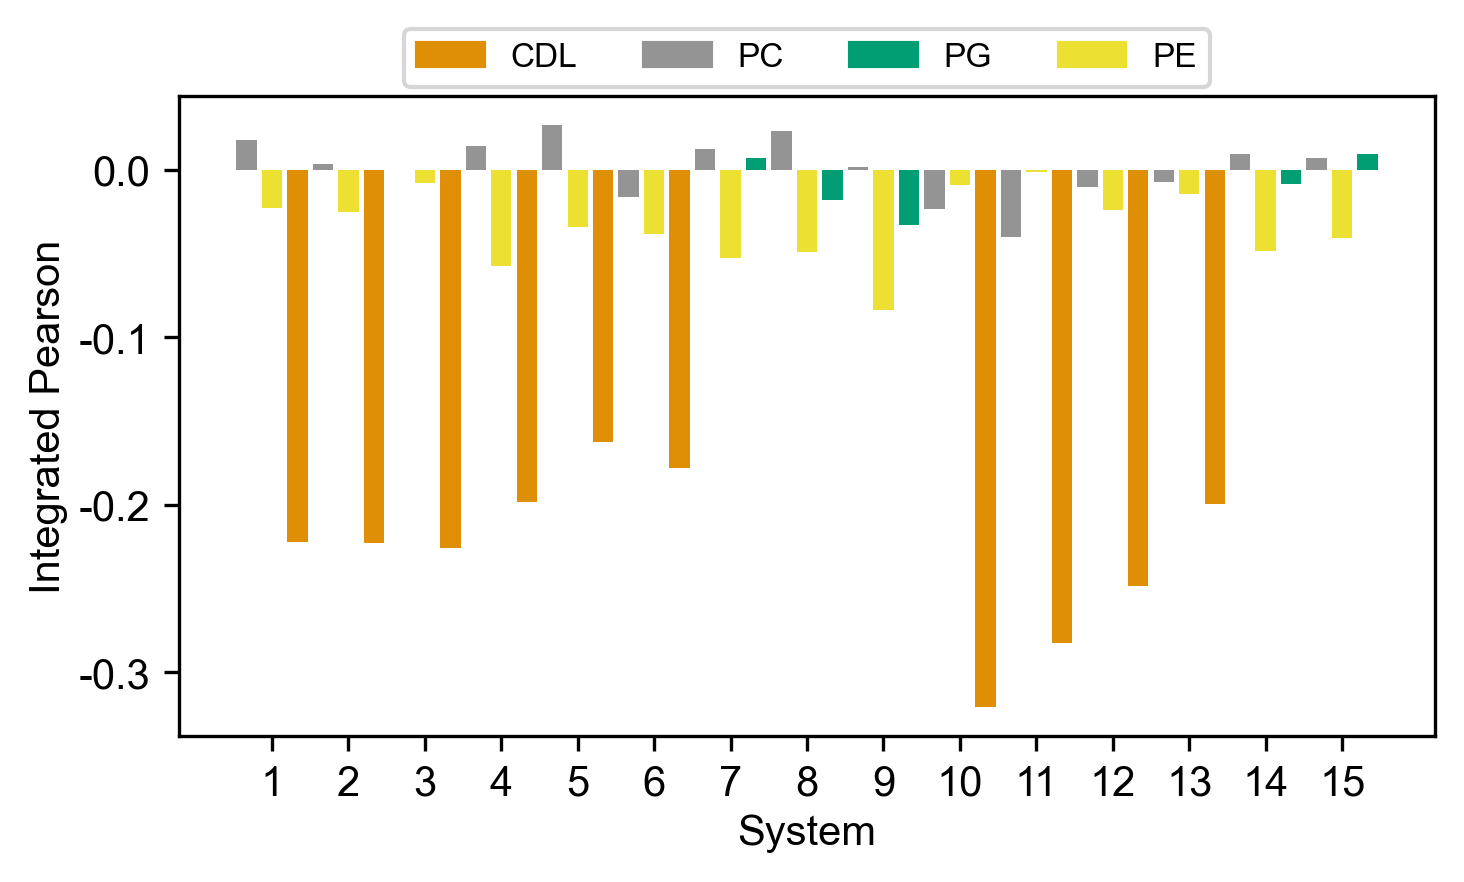

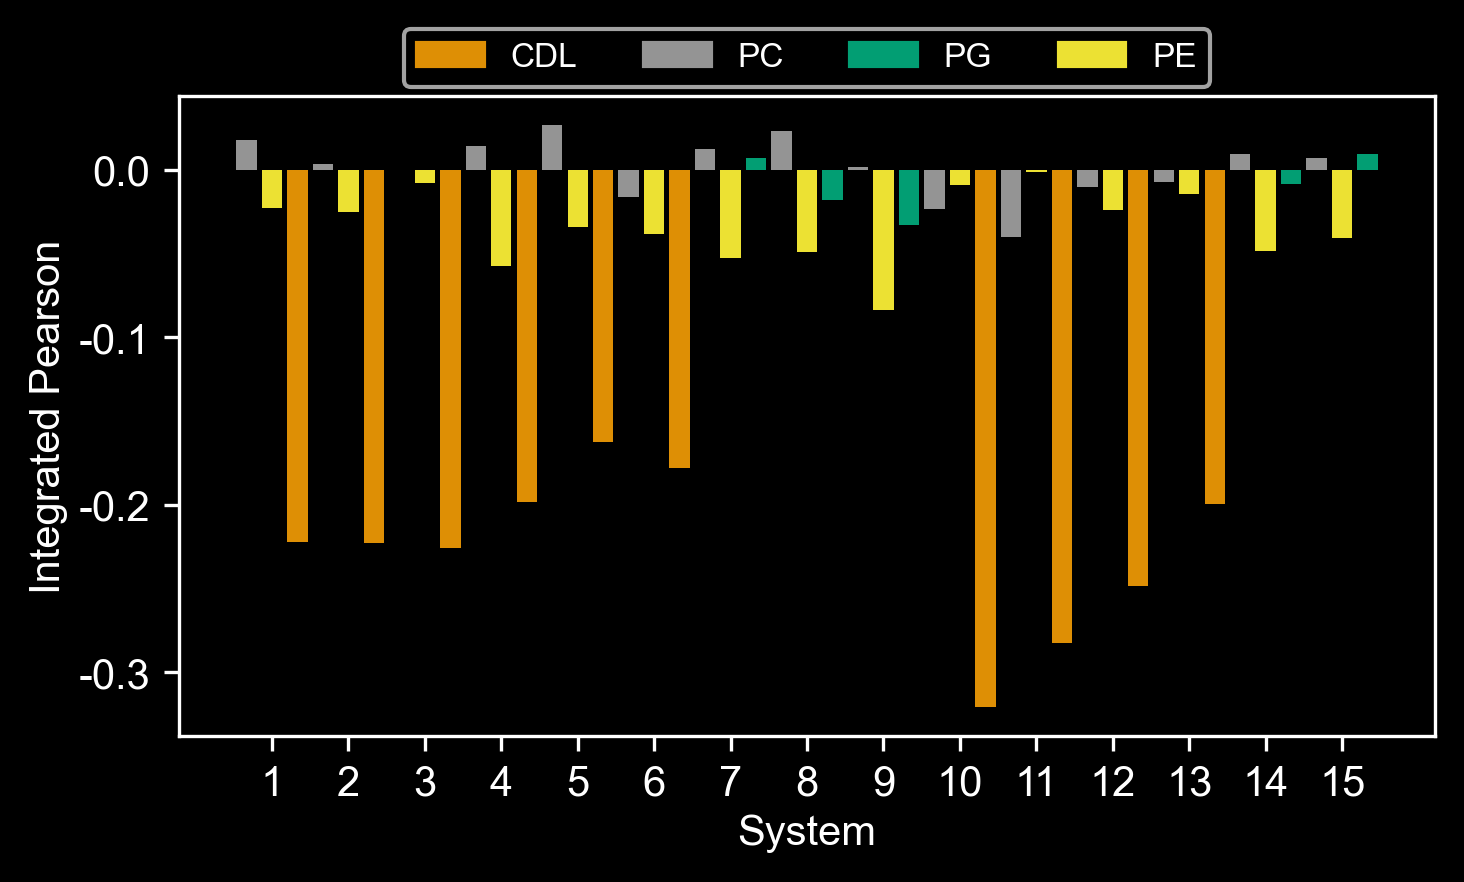

In [19]:
show_figs = True
curr_fig_path = Path("Figures/cross-leaflet-spatial-corr-summary")
curr_fig_path.mkdir(parents=True, exist_ok=True)

color_index = {"CDL": 1, "PC": 7, "PG": 2, "PE": 8}

vals = []
colors = []
for sim in range(1, 16):
    for lipid in queries.keys():
        if lipid not in cross_leaflet_correlation[str(util.remapping_dict[sim])]:
            continue
        # cross_leaflet_correlation[sim][k] = [max(acr.min(), acr.max(), key=abs), acr.min(), acr.max(), acr.mean(),  acr[20:23,20:23].mean(), acr[21,21]]
        vals.append(cross_leaflet_correlation[str(util.remapping_dict[sim])][lipid][5])
        colors.append(p[color_index[lipid]])

# print(vals)
# print(colors)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))  # sharex=True,

        ax.bar(range(len(vals)), vals, color=colors)

        ax.set_xticks(np.arange(1, len(vals), 3))
        ax.set_xticklabels(np.arange(1, 16))

        patches = [
            mpatches.Patch(color=p[1], label="CDL"),
            mpatches.Patch(color=p[7], label="PC"),
            mpatches.Patch(color=p[2], label="PG"),
            mpatches.Patch(color=p[8], label="PE"),
        ]

        box = ax.get_position()
        ax.legend(
            handles=patches, loc="upper center", ncols=4, bbox_to_anchor=(0.5, 1.13)
        )

        ax.set_ylabel("Integrated Pearson")
        ax.set_xlabel("System")

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"Pearson correlation{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)